In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/03_casos/df_53_cleaned.csv')

In [3]:
df.head()

,ano,semana,ira_no_neumonia,neumonias_men5,neumonias_60mas,hospitalizados_men5,hospitalizados_60mas,defunciones_men5,defunciones_60mas,sub_reg_nt,...,defunciones_60mas_lag_3_semana,defunciones_60mas_lag_4_semana,defunciones_60mas_lag_5_semana,defunciones_60mas_lag_6_semana,mes,bimestre,trimestre,cuatrimestre,semestre,pandemia_covid
0,2000,1,2660,14,0,0,0,0,0,53,...,0.0,0.0,0.0,0.0,1,1,1,1,1,0
1,2000,2,2567,8,0,0,0,0,0,53,...,0.0,0.0,0.0,0.0,1,1,1,1,1,0
2,2000,3,2230,15,0,0,0,0,0,53,...,0.0,0.0,0.0,0.0,1,1,1,1,1,0
3,2000,4,2067,12,0,0,0,0,0,53,...,0.0,0.0,0.0,0.0,1,1,1,1,1,0
4,2000,5,1677,8,0,0,0,0,0,53,...,0.0,0.0,0.0,0.0,2,1,1,1,1,0


Vamos a entrenar un mismo modelo de forecasting para la predicción de `hospitalizados_men5`, considerando los siguientes escenarios:

### Por años [2000 a 2023]

- Entrenar usando:  
  **Variables:** `ano`, `semana`  
  **Target:** `hospitalizados_men5`

- Entrenar usando:  
  **Variables:** `ano`, `semana`, `pandemia_covid`  
  **Target:** `hospitalizados_men5`

- Entrenar usando:  
  **Variables:** `ano`, `semana`, `ira_no_neumonia`, `neumonias_men5`, `neumonias_60mas`, `hospitalizados_60mas`, `defunciones_men5`, `defunciones_60mas`  
  **Target:** `hospitalizados_men5`

- Entrenar usando:  
  **Variables:** `ano`, `semana`, `ira_no_neumonia`, `neumonias_men5`, `neumonias_60mas`, `hospitalizados_60mas`, `defunciones_men5`, `defunciones_60mas`, y sus variables *lag* (`_lag_1_semana` a `_lag_6_semana`)  
  **Target:** `hospitalizados_men5`

- Entrenar usando:  
  **Variables:** `ano`, `semana`, `hospitalizados_60mas_lag_1_semana`, `defunciones_men5_lag_1_semana`, `defunciones_60mas_lag_1_semana`, `defunciones_men5_lag_3_semana`   
  **Target:** `hospitalizados_men5`


### Por años [2022 a 2023]

- Entrenar usando:  
  **Variables:** `ano`, `semana`  
  **Target:** `hospitalizados_men5`

- Entrenar usando:  
  **Variables:** `ano`, `semana`, `ira_no_neumonia`, `neumonias_men5`, `neumonias_60mas`, `hospitalizados_60mas`, `defunciones_men5`, `defunciones_60mas`  
  **Target:** `hospitalizados_men5`

- Entrenar usando:  
  **Variables:** `ano`, `semana`, `ira_no_neumonia`, `neumonias_men5`, `neumonias_60mas`, `hospitalizados_60mas`, `defunciones_men5`, `defunciones_60mas`, y sus variables *lag* (`_lag_1_semana` a `_lag_6_semana`)  
  **Target:** `hospitalizados_men5`

- Entrenar usando:  
  **Variables:** `ano`, `semana`, `hospitalizados_60mas_lag_1_semana`, `defunciones_men5_lag_1_semana`, `defunciones_60mas_lag_1_semana`, `defunciones_men5_lag_3_semana`   
  **Target:** `hospitalizados_men5`

## Modelos: LSTM, GRU y CNN-LSTM

Entrenaremos tres tipos de redes neuronales especializadas en series de tiempo:
- **LSTM**: Long Short-Term Memory - maneja dependencias a largo plazo
- **GRU**: Gated Recurrent Unit - versión simplificada de LSTM con menos parámetros
- **CNN-LSTM**: Combinación de redes convolucionales y LSTM para capturar patrones locales y temporales

In [4]:
# Importaciones adicionales para redes neuronales
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configurar semilla para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponible: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU disponible: []


In [5]:
# Diccionario para almacenar resultados de todos los modelos
resultados_modelos = {}

In [6]:
# Definir conjuntos de variables según los criterios especificados
variables_sets = {
    'set1_ano_semana': ['ano', 'semana'],
    
    'set2_con_pandemia': ['ano', 'semana', 'pandemia_covid'],
    
    'set3_principales': ['ano', 'semana', 'ira_no_neumonia', 'neumonias_men5', 'neumonias_60mas',
                         'hospitalizados_60mas', 'defunciones_men5', 'defunciones_60mas'],
    
    'set4_con_lags': ['ano', 'semana', 'ira_no_neumonia', 'neumonias_men5', 'neumonias_60mas',
                      'hospitalizados_60mas', 'defunciones_men5', 'defunciones_60mas'],
    
    'set5_lags_selectos': ['ano', 'semana', 'hospitalizados_60mas_lag_1_semana',
                           'defunciones_men5_lag_1_semana', 'defunciones_60mas_lag_1_semana',
                           'defunciones_men5_lag_3_semana']
}

# Agregar variables lag a set4
lag_vars = []
for var in ['ira_no_neumonia', 'neumonias_men5', 'neumonias_60mas',
            'hospitalizados_60mas', 'defunciones_men5', 'defunciones_60mas']:
    for i in range(1, 7):
        lag_vars.append(f'{var}_lag_{i}_semana')

variables_sets['set4_con_lags'].extend(lag_vars)

print("Conjuntos de variables definidos:")
for key, vars_list in variables_sets.items():
    print(f"\n{key}: {len(vars_list)} variables")
    print(f"  {', '.join(vars_list[:5])}{'...' if len(vars_list) > 5 else ''}")

Conjuntos de variables definidos:

set1_ano_semana: 2 variables
  ano, semana

set2_con_pandemia: 3 variables
  ano, semana, pandemia_covid

set3_principales: 8 variables
  ano, semana, ira_no_neumonia, neumonias_men5, neumonias_60mas...

set4_con_lags: 44 variables
  ano, semana, ira_no_neumonia, neumonias_men5, neumonias_60mas...

set5_lags_selectos: 6 variables
  ano, semana, hospitalizados_60mas_lag_1_semana, defunciones_men5_lag_1_semana, defunciones_60mas_lag_1_semana...


### Funciones de Preparación de Datos para Redes Neuronales

In [7]:
def create_sequences(X, y, time_steps=10):
    """
    Crea secuencias temporales para modelos RNN.
    
    Parameters:
    -----------
    X : array-like
        Features
    y : array-like
        Target
    time_steps : int
        Número de pasos temporales a usar como entrada
        
    Returns:
    --------
    X_seq, y_seq : arrays
        Datos en formato secuencial
    """
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

def prepare_data_for_nn(df_periodo, exog_vars, target='hospitalizados_men5', 
                        split_ratio=0.8, time_steps=10):
    """
    Prepara datos para redes neuronales con normalización y creación de secuencias.
    
    Parameters:
    -----------
    df_periodo : DataFrame
        DataFrame con los datos del periodo
    exog_vars : list
        Lista de variables a usar como features
    target : str
        Variable objetivo
    split_ratio : float
        Proporción de datos para entrenamiento
    time_steps : int
        Número de pasos temporales
        
    Returns:
    --------
    X_train_seq, X_test_seq, y_train_seq, y_test_seq, scaler_X, scaler_y
    """
    # Extraer features y target
    X = df_periodo[exog_vars].values
    y = df_periodo[target].values
    
    # Split
    split_idx = int(len(X) * split_ratio)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    # Normalización
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()
    
    # Crear secuencias
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, time_steps)
    
    return X_train_seq, X_test_seq, y_train_seq, y_test_seq, scaler_X, scaler_y

print("Funciones de preparación de datos creadas exitosamente.")

Funciones de preparación de datos creadas exitosamente.


### Arquitecturas de Redes Neuronales

In [8]:
def build_lstm_model(input_shape, units=50, dropout_rate=0.2):
    """
    Construye un modelo LSTM para predicción de series de tiempo.
    
    Parameters:
    -----------
    input_shape : tuple
        (time_steps, n_features)
    units : int
        Número de unidades LSTM
    dropout_rate : float
        Tasa de dropout para regularización
        
    Returns:
    --------
    model : keras.Model
    """
    model = Sequential([
        LSTM(units, activation='tanh', return_sequences=True, input_shape=input_shape),
        Dropout(dropout_rate),
        LSTM(units // 2, activation='tanh', return_sequences=False),
        Dropout(dropout_rate),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    
    return model

def build_gru_model(input_shape, units=50, dropout_rate=0.2):
    """
    Construye un modelo GRU para predicción de series de tiempo.
    
    Parameters:
    -----------
    input_shape : tuple
        (time_steps, n_features)
    units : int
        Número de unidades GRU
    dropout_rate : float
        Tasa de dropout para regularización
        
    Returns:
    --------
    model : keras.Model
    """
    model = Sequential([
        GRU(units, activation='tanh', return_sequences=True, input_shape=input_shape),
        Dropout(dropout_rate),
        GRU(units // 2, activation='tanh', return_sequences=False),
        Dropout(dropout_rate),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    
    return model

def build_cnn_lstm_model(input_shape, filters=64, kernel_size=3, lstm_units=50, dropout_rate=0.2):
    """
    Construye un modelo CNN-LSTM para predicción de series de tiempo.
    
    Parameters:
    -----------
    input_shape : tuple
        (time_steps, n_features)
    filters : int
        Número de filtros convolucionales
    kernel_size : int
        Tamaño del kernel convolucional
    lstm_units : int
        Número de unidades LSTM
    dropout_rate : float
        Tasa de dropout para regularización
        
    Returns:
    --------
    model : keras.Model
    """
    model = Sequential([
        Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', 
               input_shape=input_shape, padding='same'),
        MaxPooling1D(pool_size=2),
        Dropout(dropout_rate),
        
        LSTM(lstm_units, activation='tanh', return_sequences=False),
        Dropout(dropout_rate),
        
        Dense(25, activation='relu'),
        Dense(1)
    ])
    
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    
    return model

print("Arquitecturas de redes neuronales definidas:")
print("  1. LSTM - Long Short-Term Memory")
print("  2. GRU - Gated Recurrent Unit")
print("  3. CNN-LSTM - Convolutional + LSTM")

Arquitecturas de redes neuronales definidas:
  1. LSTM - Long Short-Term Memory
  2. GRU - Gated Recurrent Unit
  3. CNN-LSTM - Convolutional + LSTM


### Periodo 2000-2023 - Entrenamiento de Redes Neuronales

In [9]:
# Preparar datos para periodo 2000-2023
df_2000_2023 = df.copy().sort_values(['ano', 'semana']).reset_index(drop=True)

print(f"Total observaciones 2000-2023: {len(df_2000_2023)}")
print(f"Split: 80% train, 20% test")
print(f"Time steps para secuencias: 10")

Total observaciones 2000-2023: 1248
Split: 80% train, 20% test
Time steps para secuencias: 10


In [10]:
# Entrenar redes neuronales para periodo 2000-2023
sets_2000_2023 = ['set1_ano_semana', 'set2_con_pandemia', 'set3_principales', 
                  'set4_con_lags', 'set5_lags_selectos']

# Configuración de entrenamiento
TIME_STEPS = 10
EPOCHS = 50
BATCH_SIZE = 32

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

print(f"{'='*100}")
print(f"INICIANDO ENTRENAMIENTO DE REDES NEURONALES - PERIODO 2000-2023")
print(f"{'='*100}\n")

for set_name in sets_2000_2023:
    exog_vars = variables_sets[set_name]
    
    print(f"\n{'─'*100}")
    print(f"Conjunto de variables: {set_name} ({len(exog_vars)} variables)")
    print(f"{'─'*100}")
    
    # Nombre descriptivo
    var_desc_map = {
        'set1_ano_semana': 'ano, semana',
        'set2_con_pandemia': 'ano, semana, pandemia_covid',
        'set3_principales': 'principales',
        'set4_con_lags': 'principales + lags',
        'set5_lags_selectos': 'lags selectos'
    }
    var_desc = var_desc_map.get(set_name, set_name)
    
    try:
        # Preparar datos
        X_train_seq, X_test_seq, y_train_seq, y_test_seq, scaler_X, scaler_y = prepare_data_for_nn(
            df_2000_2023, exog_vars, target='hospitalizados_men5', 
            split_ratio=0.8, time_steps=TIME_STEPS
        )
        
        input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
        print(f"  Shape - Train: {X_train_seq.shape}, Test: {X_test_seq.shape}")
        
        # ==================== LSTM ====================
        print(f"\n  Entrenando LSTM...")
        model_lstm = build_lstm_model(input_shape)
        
        history_lstm = model_lstm.fit(
            X_train_seq, y_train_seq,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            validation_split=0.2,
            callbacks=[early_stopping, reduce_lr],
            verbose=0
        )
        
        # Predicciones
        y_pred_lstm_scaled = model_lstm.predict(X_test_seq, verbose=0).flatten()
        y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm_scaled.reshape(-1, 1)).flatten()
        y_test_original = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()
        
        # Métricas
        mae_lstm = mean_absolute_error(y_test_original, y_pred_lstm)
        rmse_lstm = np.sqrt(mean_squared_error(y_test_original, y_pred_lstm))
        r2_lstm = r2_score(y_test_original, y_pred_lstm)
        
        resultados_modelos[f'LSTM_2000-2023_{set_name}'] = {
            'periodo': '2000-2023',
            'modelo': 'LSTM',
            'variables': var_desc,
            'MAE': mae_lstm,
            'RMSE': rmse_lstm,
            'R2': r2_lstm
        }
        
        print(f"  ✓ LSTM | MAE: {mae_lstm:.3f} | RMSE: {rmse_lstm:.3f} | R²: {r2_lstm:.4f}")
        
        # ==================== GRU ====================
        print(f"  Entrenando GRU...")
        model_gru = build_gru_model(input_shape)
        
        history_gru = model_gru.fit(
            X_train_seq, y_train_seq,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            validation_split=0.2,
            callbacks=[early_stopping, reduce_lr],
            verbose=0
        )
        
        # Predicciones
        y_pred_gru_scaled = model_gru.predict(X_test_seq, verbose=0).flatten()
        y_pred_gru = scaler_y.inverse_transform(y_pred_gru_scaled.reshape(-1, 1)).flatten()
        
        # Métricas
        mae_gru = mean_absolute_error(y_test_original, y_pred_gru)
        rmse_gru = np.sqrt(mean_squared_error(y_test_original, y_pred_gru))
        r2_gru = r2_score(y_test_original, y_pred_gru)
        
        resultados_modelos[f'GRU_2000-2023_{set_name}'] = {
            'periodo': '2000-2023',
            'modelo': 'GRU',
            'variables': var_desc,
            'MAE': mae_gru,
            'RMSE': rmse_gru,
            'R2': r2_gru
        }
        
        print(f"  ✓ GRU  | MAE: {mae_gru:.3f} | RMSE: {rmse_gru:.3f} | R²: {r2_gru:.4f}")
        
        # ==================== CNN-LSTM ====================
        print(f"  Entrenando CNN-LSTM...")
        model_cnn_lstm = build_cnn_lstm_model(input_shape)
        
        history_cnn_lstm = model_cnn_lstm.fit(
            X_train_seq, y_train_seq,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            validation_split=0.2,
            callbacks=[early_stopping, reduce_lr],
            verbose=0
        )
        
        # Predicciones
        y_pred_cnn_lstm_scaled = model_cnn_lstm.predict(X_test_seq, verbose=0).flatten()
        y_pred_cnn_lstm = scaler_y.inverse_transform(y_pred_cnn_lstm_scaled.reshape(-1, 1)).flatten()
        
        # Métricas
        mae_cnn_lstm = mean_absolute_error(y_test_original, y_pred_cnn_lstm)
        rmse_cnn_lstm = np.sqrt(mean_squared_error(y_test_original, y_pred_cnn_lstm))
        r2_cnn_lstm = r2_score(y_test_original, y_pred_cnn_lstm)
        
        resultados_modelos[f'CNN-LSTM_2000-2023_{set_name}'] = {
            'periodo': '2000-2023',
            'modelo': 'CNN-LSTM',
            'variables': var_desc,
            'MAE': mae_cnn_lstm,
            'RMSE': rmse_cnn_lstm,
            'R2': r2_cnn_lstm
        }
        
        print(f"  ✓ CNN-LSTM | MAE: {mae_cnn_lstm:.3f} | RMSE: {rmse_cnn_lstm:.3f} | R²: {r2_cnn_lstm:.4f}")
        
        # Limpiar memoria
        del model_lstm, model_gru, model_cnn_lstm
        tf.keras.backend.clear_session()
        
    except Exception as e:
        print(f"  ✗ Error en {set_name}: {str(e)[:80]}")

print(f"\n{'='*100}")
print(f"Total de modelos entrenados (2000-2023): {len([k for k in resultados_modelos.keys() if '2000-2023' in k])}")
print(f"{'='*100}")

INICIANDO ENTRENAMIENTO DE REDES NEURONALES - PERIODO 2000-2023


────────────────────────────────────────────────────────────────────────────────────────────────────
Conjunto de variables: set1_ano_semana (2 variables)
────────────────────────────────────────────────────────────────────────────────────────────────────
  Shape - Train: (988, 10, 2), Test: (240, 10, 2)

  Entrenando LSTM...
  ✓ LSTM | MAE: 3.003 | RMSE: 3.764 | R²: -0.0232
  Entrenando GRU...
  ✓ GRU  | MAE: 3.061 | RMSE: 4.081 | R²: -0.2027
  Entrenando CNN-LSTM...
  ✓ CNN-LSTM | MAE: 2.975 | RMSE: 3.715 | R²: 0.0031


────────────────────────────────────────────────────────────────────────────────────────────────────
Conjunto de variables: set2_con_pandemia (3 variables)
────────────────────────────────────────────────────────────────────────────────────────────────────
  Shape - Train: (988, 10, 3), Test: (240, 10, 3)

  Entrenando LSTM...
  ✓ LSTM | MAE: 3.624 | RMSE: 4.214 | R²: -0.2823
  Entrenando GRU...
  ✓ GRU 

### Periodo 2022-2023 - Entrenamiento de Redes Neuronales

In [11]:
# Preparar datos para periodo 2022-2023
df_2022_2023 = df[df['ano'] >= 2022].copy().sort_values(['ano', 'semana']).reset_index(drop=True)

print(f"Total observaciones 2022-2023: {len(df_2022_2023)}")
print(f"Split: 80% train, 20% test")

Total observaciones 2022-2023: 104
Split: 80% train, 20% test


In [12]:
# Entrenar redes neuronales para periodo 2022-2023
sets_2022_2023 = ['set1_ano_semana', 'set3_principales', 'set4_con_lags', 'set5_lags_selectos']

print(f"{'='*100}")
print(f"INICIANDO ENTRENAMIENTO DE REDES NEURONALES - PERIODO 2022-2023")
print(f"{'='*100}\n")

for set_name in sets_2022_2023:
    exog_vars = variables_sets[set_name]
    
    print(f"\n{'─'*100}")
    print(f"Conjunto de variables: {set_name} ({len(exog_vars)} variables)")
    print(f"{'─'*100}")
    
    # Nombre descriptivo
    var_desc_map = {
        'set1_ano_semana': 'ano, semana',
        'set3_principales': 'principales',
        'set4_con_lags': 'principales + lags',
        'set5_lags_selectos': 'lags selectos'
    }
    var_desc = var_desc_map.get(set_name, set_name)
    
    try:
        # Preparar datos
        X_train_seq, X_test_seq, y_train_seq, y_test_seq, scaler_X, scaler_y = prepare_data_for_nn(
            df_2022_2023, exog_vars, target='hospitalizados_men5', 
            split_ratio=0.8, time_steps=TIME_STEPS
        )
        
        input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
        print(f"  Shape - Train: {X_train_seq.shape}, Test: {X_test_seq.shape}")
        
        # ==================== LSTM ====================
        print(f"\n  Entrenando LSTM...")
        model_lstm = build_lstm_model(input_shape)
        
        history_lstm = model_lstm.fit(
            X_train_seq, y_train_seq,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            validation_split=0.2,
            callbacks=[early_stopping, reduce_lr],
            verbose=0
        )
        
        # Predicciones
        y_pred_lstm_scaled = model_lstm.predict(X_test_seq, verbose=0).flatten()
        y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm_scaled.reshape(-1, 1)).flatten()
        y_test_original = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()
        
        # Métricas
        mae_lstm = mean_absolute_error(y_test_original, y_pred_lstm)
        rmse_lstm = np.sqrt(mean_squared_error(y_test_original, y_pred_lstm))
        r2_lstm = r2_score(y_test_original, y_pred_lstm)
        
        resultados_modelos[f'LSTM_2022-2023_{set_name}'] = {
            'periodo': '2022-2023',
            'modelo': 'LSTM',
            'variables': var_desc,
            'MAE': mae_lstm,
            'RMSE': rmse_lstm,
            'R2': r2_lstm
        }
        
        print(f"  ✓ LSTM | MAE: {mae_lstm:.3f} | RMSE: {rmse_lstm:.3f} | R²: {r2_lstm:.4f}")
        
        # ==================== GRU ====================
        print(f"  Entrenando GRU...")
        model_gru = build_gru_model(input_shape)
        
        history_gru = model_gru.fit(
            X_train_seq, y_train_seq,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            validation_split=0.2,
            callbacks=[early_stopping, reduce_lr],
            verbose=0
        )
        
        # Predicciones
        y_pred_gru_scaled = model_gru.predict(X_test_seq, verbose=0).flatten()
        y_pred_gru = scaler_y.inverse_transform(y_pred_gru_scaled.reshape(-1, 1)).flatten()
        
        # Métricas
        mae_gru = mean_absolute_error(y_test_original, y_pred_gru)
        rmse_gru = np.sqrt(mean_squared_error(y_test_original, y_pred_gru))
        r2_gru = r2_score(y_test_original, y_pred_gru)
        
        resultados_modelos[f'GRU_2022-2023_{set_name}'] = {
            'periodo': '2022-2023',
            'modelo': 'GRU',
            'variables': var_desc,
            'MAE': mae_gru,
            'RMSE': rmse_gru,
            'R2': r2_gru
        }
        
        print(f"  ✓ GRU  | MAE: {mae_gru:.3f} | RMSE: {rmse_gru:.3f} | R²: {r2_gru:.4f}")
        
        # ==================== CNN-LSTM ====================
        print(f"  Entrenando CNN-LSTM...")
        model_cnn_lstm = build_cnn_lstm_model(input_shape)
        
        history_cnn_lstm = model_cnn_lstm.fit(
            X_train_seq, y_train_seq,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            validation_split=0.2,
            callbacks=[early_stopping, reduce_lr],
            verbose=0
        )
        
        # Predicciones
        y_pred_cnn_lstm_scaled = model_cnn_lstm.predict(X_test_seq, verbose=0).flatten()
        y_pred_cnn_lstm = scaler_y.inverse_transform(y_pred_cnn_lstm_scaled.reshape(-1, 1)).flatten()
        
        # Métricas
        mae_cnn_lstm = mean_absolute_error(y_test_original, y_pred_cnn_lstm)
        rmse_cnn_lstm = np.sqrt(mean_squared_error(y_test_original, y_pred_cnn_lstm))
        r2_cnn_lstm = r2_score(y_test_original, y_pred_cnn_lstm)
        
        resultados_modelos[f'CNN-LSTM_2022-2023_{set_name}'] = {
            'periodo': '2022-2023',
            'modelo': 'CNN-LSTM',
            'variables': var_desc,
            'MAE': mae_cnn_lstm,
            'RMSE': rmse_cnn_lstm,
            'R2': r2_cnn_lstm
        }
        
        print(f"  ✓ CNN-LSTM | MAE: {mae_cnn_lstm:.3f} | RMSE: {rmse_cnn_lstm:.3f} | R²: {r2_cnn_lstm:.4f}")
        
        # Limpiar memoria
        del model_lstm, model_gru, model_cnn_lstm
        tf.keras.backend.clear_session()
        
    except Exception as e:
        print(f"  ✗ Error en {set_name}: {str(e)[:80]}")

print(f"\n{'='*100}")
print(f"Total de modelos entrenados: {len(resultados_modelos)}")
print(f"{'='*100}")

INICIANDO ENTRENAMIENTO DE REDES NEURONALES - PERIODO 2022-2023


────────────────────────────────────────────────────────────────────────────────────────────────────
Conjunto de variables: set1_ano_semana (2 variables)
────────────────────────────────────────────────────────────────────────────────────────────────────
  Shape - Train: (73, 10, 2), Test: (11, 10, 2)

  Entrenando LSTM...
  ✓ LSTM | MAE: 1.552 | RMSE: 1.783 | R²: -0.0681
  Entrenando GRU...
  ✓ GRU  | MAE: 1.533 | RMSE: 1.755 | R²: -0.0350
  Entrenando CNN-LSTM...
  ✓ CNN-LSTM | MAE: 1.460 | RMSE: 1.728 | R²: -0.0039

────────────────────────────────────────────────────────────────────────────────────────────────────
Conjunto de variables: set3_principales (8 variables)
────────────────────────────────────────────────────────────────────────────────────────────────────
  Shape - Train: (73, 10, 8), Test: (11, 10, 8)

  Entrenando LSTM...
  ✓ LSTM | MAE: 1.566 | RMSE: 1.804 | R²: -0.0936
  Entrenando GRU...
  ✓ GRU  | MA

---

## Tabla Comparativa - Resultados de Redes Neuronales

In [13]:
# Crear DataFrame con todos los resultados
df_resultados = pd.DataFrame(resultados_modelos).T
df_resultados = df_resultados.reset_index(drop=True)

# Redondear métricas
df_resultados[['MAE', 'RMSE', 'R2']] = df_resultados[['MAE', 'RMSE', 'R2']].round(4)

# Ordenar resultados por periodo, modelo y variables
df_resultados = df_resultados.sort_values(['periodo', 'modelo', 'variables']).reset_index(drop=True)

print("="*120)
print("TABLA COMPARATIVA - REDES NEURONALES: LSTM, GRU, CNN-LSTM")
print("="*120)
print("\nTarget: hospitalizados_men5")
print("\nFormato: periodo, modelo, variables, MAE, RMSE, R2")
print("\nModelos:")
print("  - LSTM: Long Short-Term Memory")
print("  - GRU: Gated Recurrent Unit")
print("  - CNN-LSTM: Convolutional Neural Network + LSTM")
print("\nColumnas:")
print("  - Periodo: Rango de años utilizado")
print("  - Modelo: Tipo de red neuronal")
print("  - Variables: Conjunto de variables utilizadas")
print("  - MAE: Mean Absolute Error (menor es mejor)")
print("  - RMSE: Root Mean Squared Error (menor es mejor)")
print("  - R²: Coeficiente de Determinación (mayor es mejor, cercano a 1)")
print("\n" + "="*120)

# Mostrar tabla con el formato especificado
print(df_resultados.to_string(index=True))
print("\n" + "="*120)

TABLA COMPARATIVA - REDES NEURONALES: LSTM, GRU, CNN-LSTM

Target: hospitalizados_men5

Formato: periodo, modelo, variables, MAE, RMSE, R2

Modelos:
  - LSTM: Long Short-Term Memory
  - GRU: Gated Recurrent Unit
  - CNN-LSTM: Convolutional Neural Network + LSTM

Columnas:
  - Periodo: Rango de años utilizado
  - Modelo: Tipo de red neuronal
  - Variables: Conjunto de variables utilizadas
  - MAE: Mean Absolute Error (menor es mejor)
  - RMSE: Root Mean Squared Error (menor es mejor)
  - R²: Coeficiente de Determinación (mayor es mejor, cercano a 1)

      periodo    modelo                    variables       MAE      RMSE        R2
0   2000-2023  CNN-LSTM                  ano, semana  2.975386  3.715468  0.003109
1   2000-2023  CNN-LSTM  ano, semana, pandemia_covid  3.334461  3.922323 -0.110982
2   2000-2023  CNN-LSTM                lags selectos  3.010249  3.578288  0.075363
3   2000-2023  CNN-LSTM                  principales  2.260318   3.19485  0.262908
4   2000-2023  CNN-LSTM      

### Visualización de Resultados

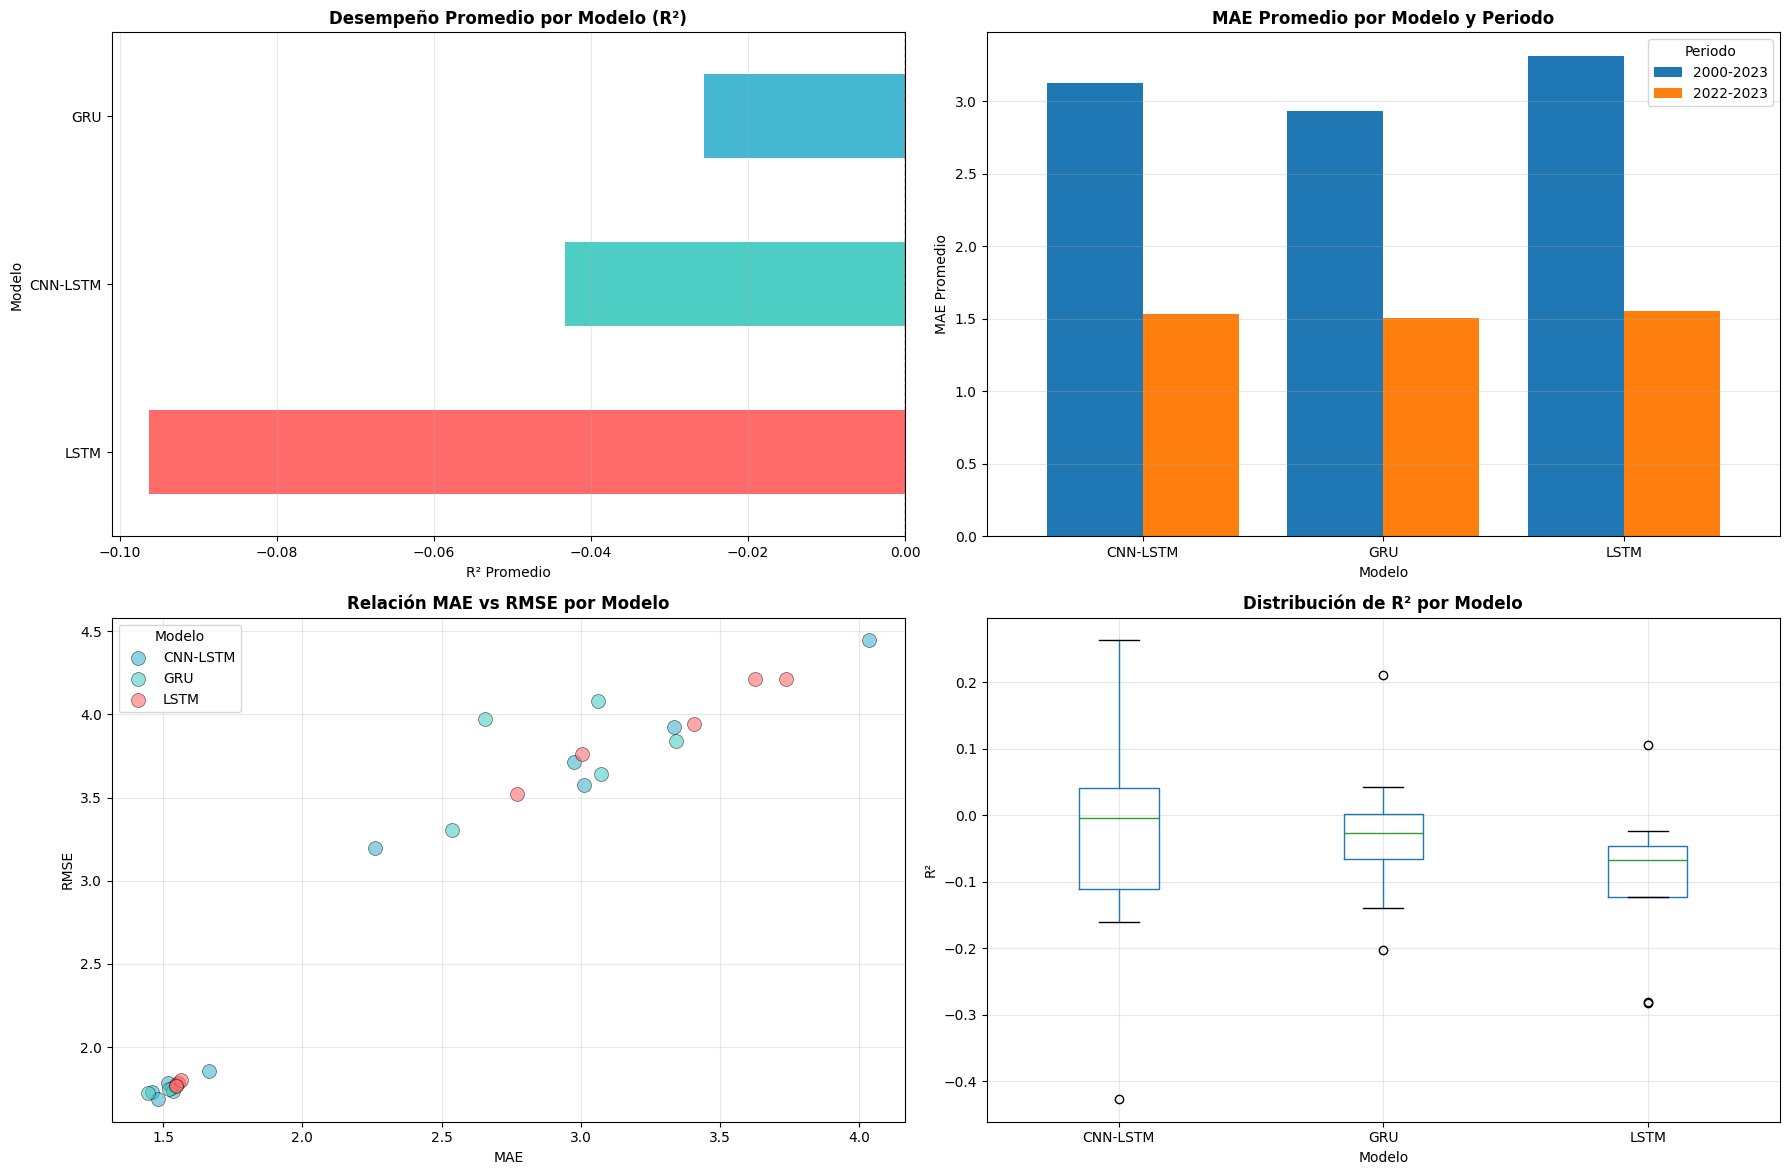

In [14]:
# Visualización comparativa de redes neuronales
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Gráfico 1: Comparación de R² por modelo
ax1 = axes[0, 0]
r2_por_modelo = df_resultados.groupby('modelo')['R2'].mean().sort_values()
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
r2_por_modelo.plot(kind='barh', ax=ax1, color=colors)
ax1.set_xlabel('R² Promedio')
ax1.set_ylabel('Modelo')
ax1.set_title('Desempeño Promedio por Modelo (R²)', fontsize=12, fontweight='bold')
ax1.axvline(x=0, color='red', linestyle='--', linewidth=1)
ax1.grid(axis='x', alpha=0.3)

# Gráfico 2: MAE por modelo y periodo
ax2 = axes[0, 1]
df_pivot_mae = df_resultados.pivot_table(values='MAE', index='modelo', columns='periodo', aggfunc='mean')
df_pivot_mae.plot(kind='bar', ax=ax2, width=0.8)
ax2.set_xlabel('Modelo')
ax2.set_ylabel('MAE Promedio')
ax2.set_title('MAE Promedio por Modelo y Periodo', fontsize=12, fontweight='bold')
ax2.legend(title='Periodo', loc='upper right')
ax2.grid(axis='y', alpha=0.3)
ax2.tick_params(axis='x', rotation=0)

# Gráfico 3: RMSE vs MAE coloreado por modelo
ax3 = axes[1, 0]
modelos_unicos = df_resultados['modelo'].unique()
colors_map = {'LSTM': '#FF6B6B', 'GRU': '#4ECDC4', 'CNN-LSTM': '#45B7D1'}
for modelo in modelos_unicos:
    df_modelo = df_resultados[df_resultados['modelo'] == modelo]
    ax3.scatter(df_modelo['MAE'], df_modelo['RMSE'], 
                label=modelo, s=100, alpha=0.6, 
                color=colors_map.get(modelo, 'gray'),
                edgecolors='black', linewidth=0.5)
ax3.set_xlabel('MAE')
ax3.set_ylabel('RMSE')
ax3.set_title('Relación MAE vs RMSE por Modelo', fontsize=12, fontweight='bold')
ax3.legend(title='Modelo')
ax3.grid(True, alpha=0.3)

# Gráfico 4: Distribución de R² por modelo (boxplot)
ax4 = axes[1, 1]
df_resultados.boxplot(column='R2', by='modelo', ax=ax4)
ax4.set_xlabel('Modelo')
ax4.set_ylabel('R²')
ax4.set_title('Distribución de R² por Modelo', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)
plt.suptitle('')

plt.tight_layout()
plt.show()

### Exportar Resultados

In [15]:
# Crear directorio de resultados si no existe
import os
output_dir = '../data/04_resultados_modelos'
os.makedirs(output_dir, exist_ok=True)

# Guardar resultados completos en CSV con formato: periodo,modelo,variables,MAE,RMSE,R2
output_path_full = f'{output_dir}/resultados_redes_neuronales_hospitalizados_men5_completo.csv'
df_resultados.to_csv(output_path_full, index=False)
print(f"✓ Resultados completos guardados en: {output_path_full}")
print(f"  Formato: periodo, modelo, variables, MAE, RMSE, R2")

# Guardar resumen por modelo
output_path_resumen_modelo = f'{output_dir}/resultados_redes_neuronales_hospitalizados_men5_resumen_modelo.csv'
df_resumen_modelo = df_resultados.groupby('modelo').agg({
    'MAE': ['mean', 'std', 'min', 'max'],
    'RMSE': ['mean', 'std', 'min', 'max'],
    'R2': ['mean', 'std', 'min', 'max']
}).round(4)
df_resumen_modelo.to_csv(output_path_resumen_modelo)
print(f"✓ Resumen por modelo guardado en: {output_path_resumen_modelo}")

# Guardar resumen por periodo
output_path_resumen_periodo = f'{output_dir}/resultados_redes_neuronales_hospitalizados_men5_resumen_periodo.csv'
df_resumen_periodo = df_resultados.groupby('periodo').agg({
    'MAE': ['mean', 'std', 'min', 'max'],
    'RMSE': ['mean', 'std', 'min', 'max'],
    'R2': ['mean', 'std', 'min', 'max']
}).round(4)
df_resumen_periodo.to_csv(output_path_resumen_periodo)
print(f"✓ Resumen por periodo guardado en: {output_path_resumen_periodo}")

# Guardar top modelos ordenados por R²
output_path_top = f'{output_dir}/resultados_redes_neuronales_hospitalizados_men5_top10.csv'
df_top = df_resultados.nlargest(10, 'R2')[['periodo', 'modelo', 'variables', 'MAE', 'RMSE', 'R2']]
df_top.to_csv(output_path_top, index=False)
print(f"✓ Top 10 modelos guardados en: {output_path_top}")

# Mejores modelos
mejor_mae = df_resultados.loc[df_resultados['MAE'].idxmin()]
mejor_rmse = df_resultados.loc[df_resultados['RMSE'].idxmin()]
mejor_r2 = df_resultados.loc[df_resultados['R2'].idxmax()]

# Resumen final
print("\n" + "="*120)
print("RESUMEN FINAL")
print("="*120)
print(f"\nTotal de modelos entrenados: {len(df_resultados)}")
print(f"Periodos analizados: {df_resultados['periodo'].nunique()}")
print(f"  Periodos: {list(df_resultados['periodo'].unique())}")
print(f"Modelos de redes neuronales: {df_resultados['modelo'].nunique()}")
print(f"  Modelos: {list(df_resultados['modelo'].unique())}")
print(f"Conjuntos de variables: {df_resultados['variables'].nunique()}")
print(f"  Variables: {list(df_resultados['variables'].unique())}")

print(f"\nTarget: hospitalizados_men5")
print(f"Time steps: 10")
print(f"Epochs: 50 (con Early Stopping)")
print(f"Batch size: 32")

print(f"\n{'─'*120}")
print("MEJORES MODELOS:")
print(f"{'─'*120}")

print(f"\nMenor MAE: {mejor_mae['MAE']:.4f}")
print(f"  Modelo: {mejor_mae['modelo']}")
print(f"  Periodo: {mejor_mae['periodo']}")
print(f"  Variables: {mejor_mae['variables']}")
print(f"  RMSE: {mejor_mae['RMSE']:.4f}")
print(f"  R²: {mejor_mae['R2']:.4f}")

print(f"\nMenor RMSE: {mejor_rmse['RMSE']:.4f}")
print(f"  Modelo: {mejor_rmse['modelo']}")
print(f"  Periodo: {mejor_rmse['periodo']}")
print(f"  Variables: {mejor_rmse['variables']}")
print(f"  MAE: {mejor_rmse['MAE']:.4f}")
print(f"  R²: {mejor_rmse['R2']:.4f}")

print(f"\nMayor R²: {mejor_r2['R2']:.4f}")
print(f"  Modelo: {mejor_r2['modelo']}")
print(f"  Periodo: {mejor_r2['periodo']}")
print(f"  Variables: {mejor_r2['variables']}")
print(f"  MAE: {mejor_r2['MAE']:.4f}")
print(f"  RMSE: {mejor_r2['RMSE']:.4f}")

print("\n" + "="*120)
print("Archivos de resultados generados exitosamente.")
print("="*120)

✓ Resultados completos guardados en: ../data/04_resultados_modelos/resultados_redes_neuronales_hospitalizados_men5_completo.csv
  Formato: periodo, modelo, variables, MAE, RMSE, R2
✓ Resumen por modelo guardado en: ../data/04_resultados_modelos/resultados_redes_neuronales_hospitalizados_men5_resumen_modelo.csv
✓ Resumen por periodo guardado en: ../data/04_resultados_modelos/resultados_redes_neuronales_hospitalizados_men5_resumen_periodo.csv


TypeError: Column 'R2' has dtype object, cannot use method 'nlargest' with this dtype